In [3]:
from google.colab import drive 
drive.mount('/mntDrive') 
%cd "/mntDrive/My Drive"
!pwd

Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).
/mntDrive/My Drive
/mntDrive/My Drive


# New section

In [4]:

%%time
from __future__ import division, print_function

# operating system interfaces
import os
# to store objects as file
import pickle
from datetime import datetime

# libraries for visaulization
import matplotlib as mpl
import matplotlib.pyplot as plt
# libraries for data storage using np array and panel data of pandas
# also used for scietific and statistical calculations
import numpy as np
import pandas as pd
import scipy.stats as stats


import plotly.express as px

import seaborn as sns

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

CPU times: user 441 ms, sys: 126 ms, total: 567 ms
Wall time: 1.38 s


In [5]:
# If you edit a module file, Jupyter’s autoreload extension reloads imported modules:
%load_ext autoreload
%autoreload
%load_ext google.colab.data_table

In [6]:
# global parameters
chunk_size = 10000
phase_angle_file = "phase-angle-1s_2019-09-01_2020-09-30.csv"
frequency_file='frequency-1s_2019-09-01_2020-09-30.csv'

In [7]:
%%time
chunkTemp = []

for chunk in pd.read_csv(phase_angle_file, parse_dates = ['time'], keep_date_col = True, chunksize=chunk_size, iterator=True, low_memory=False):

    #REPLACING BLANK SPACES AT COLUMNS' NAMES FOR SQL OPTIMIZATION
    chunk = chunk.rename(columns = {c: c.replace(' ', '') for c in chunk.columns})
    
    # BUFFER THE CHUNKS IN ORDER TO LOAD YOUR WHOLE DATASET OR DO YOUR PROCESSING OVER A CHUNK AND STORE THE RESULT OF IT
    chunk = chunk.set_index(['time'])
    chunk = chunk.resample('15 min').mean()
    chunk['dt_col'] = chunk.index
    chunk = chunk.assign(Date=chunk.dt_col.dt.date, Time=chunk.dt_col.dt.time)
    chunk.drop('dt_col', axis=1, inplace=True)
    chunkTemp.append(chunk) 

#!  NEVER DO pd.concat OR pd.DataFrame() INSIDE A LOOP
print("Database: CONCATENATING CHUNKS INTO A SINGLE DATAFRAME")
phase_angle_df = pd.concat(chunkTemp)
print("Database: LOADED")

Database: CONCATENATING CHUNKS INTO A SINGLE DATAFRAME
Database: LOADED
CPU times: user 1min 27s, sys: 4.35 s, total: 1min 32s
Wall time: 1min 41s


In [8]:
%%time
chunkTemp = []

for chunk in pd.read_csv(frequency_file, parse_dates = ['time'], keep_date_col = True, chunksize=chunk_size, iterator=True, low_memory=False):

    #REPLACING BLANK SPACES AT COLUMNS' NAMES FOR SQL OPTIMIZATION
    chunk = chunk.rename(columns = {c: c.replace(' ', '') for c in chunk.columns})
    
    # BUFFER THE CHUNKS IN ORDER TO LOAD YOUR WHOLE DATASET OR DO YOUR PROCESSING OVER A CHUNK AND STORE THE RESULT OF IT
    chunk = chunk.set_index(['time'])
    chunk = chunk.resample('15 min').mean()
    chunk['dt_col'] = chunk.index
    chunk = chunk.assign(Date=chunk.dt_col.dt.date, Time=chunk.dt_col.dt.time)
    chunk.drop('dt_col', axis=1, inplace=True)
    chunkTemp.append(chunk) 

#!  NEVER DO pd.concat OR pd.DataFrame() INSIDE A LOOP
print("Database: CONCATENATING CHUNKS INTO A SINGLE DATAFRAME")
frequency_df = pd.concat(chunkTemp)
print("Database: LOADED")

Database: CONCATENATING CHUNKS INTO A SINGLE DATAFRAME
Database: LOADED
CPU times: user 1min 36s, sys: 3.46 s, total: 1min 40s
Wall time: 1min 58s


In [9]:
# Impute missing values using mean
phase_angle_df_imputed = phase_angle_df.fillna(phase_angle_df.mean())
frequency_df_imputed=frequency_df.fillna(frequency_df.mean())

phase_angle_df_imputed.reset_index(inplace=True)
frequency_df_imputed.reset_index(inplace=True)

df=phase_angle_df_imputed[['time','Schondorf','Herzogenrath']]
df[['Schondorf_freq','Herzogenrath_freq']]=frequency_df_imputed[['Schondorf','Herzogenrath']]
df.rename(columns={'Schondorf': 'Schondorf_phasor', 'Herzogenrath': 'Herzogenrath_phasor'}, inplace=True)
df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,time,Schondorf_phasor,Herzogenrath_phasor,Schondorf_freq,Herzogenrath_freq
0,2019-09-01 00:00:00,179.578889,171.034444,49.972099,49.972083
1,2019-09-01 00:15:00,156.652222,199.253333,49.998629,49.998652
2,2019-09-01 00:30:00,124.571111,224.488889,49.998810,49.998824
3,2019-09-01 00:45:00,180.196667,208.055556,49.993570,49.993625
4,2019-09-01 01:00:00,167.571111,188.471111,49.998655,49.998646
...,...,...,...,...,...
41052,2020-09-30 22:45:00,182.097500,182.831250,50.017657,50.017610
41053,2020-09-30 23:00:00,184.171111,182.785556,49.975244,49.975164
41054,2020-09-30 23:15:00,164.455556,167.392222,50.002139,50.002030
41055,2020-09-30 23:30:00,197.504444,199.250000,50.009075,50.009023


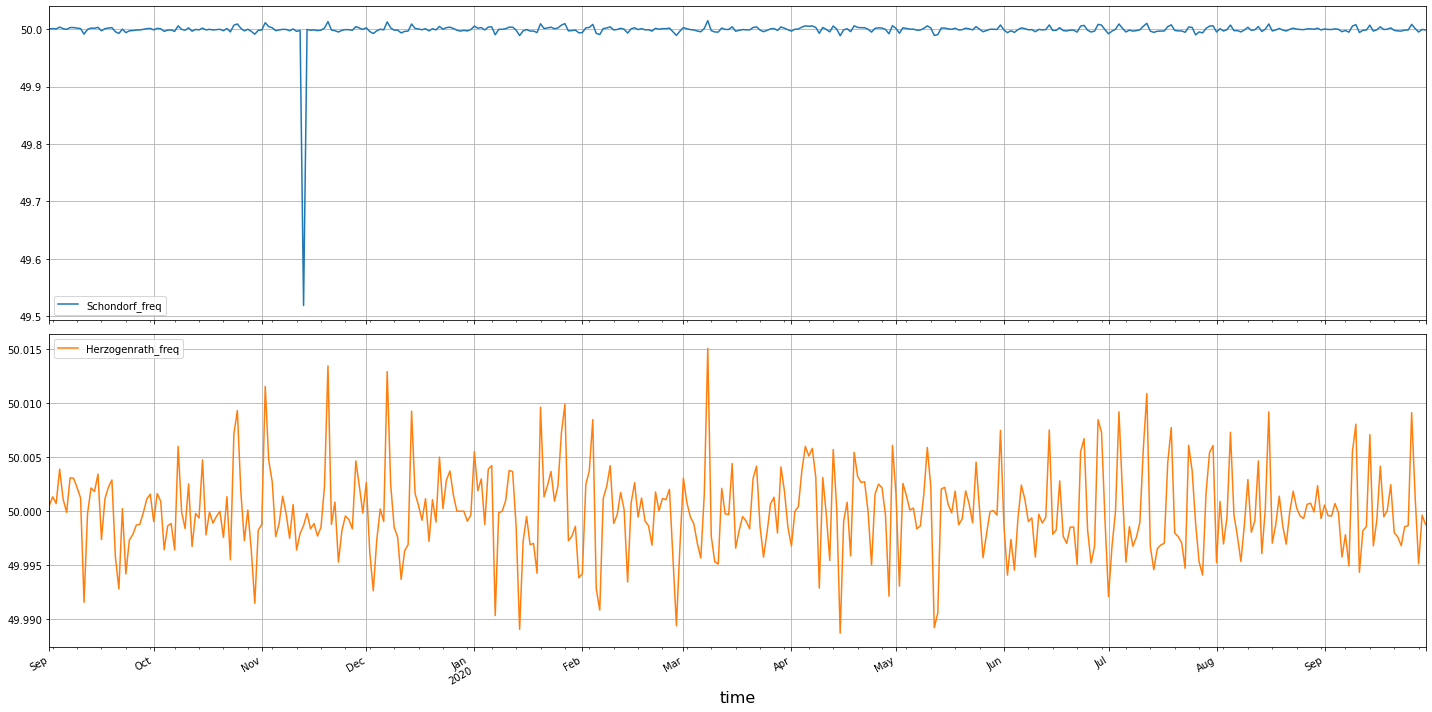

In [10]:
df.set_index('time',inplace=True)
#df[['Schondorf_freq','Herzogenrath_freq']].plot(grid = True, subplots=True, figsize = (20,10))
df[['Schondorf_freq','Herzogenrath_freq']].resample('D').mean().plot(grid = True, subplots=True, figsize = (20,10))
plt.xlabel('time', fontsize=16)
plt.legend(loc="upper left")
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Sine of phasor difference between Schondorf and Herzogenrath')

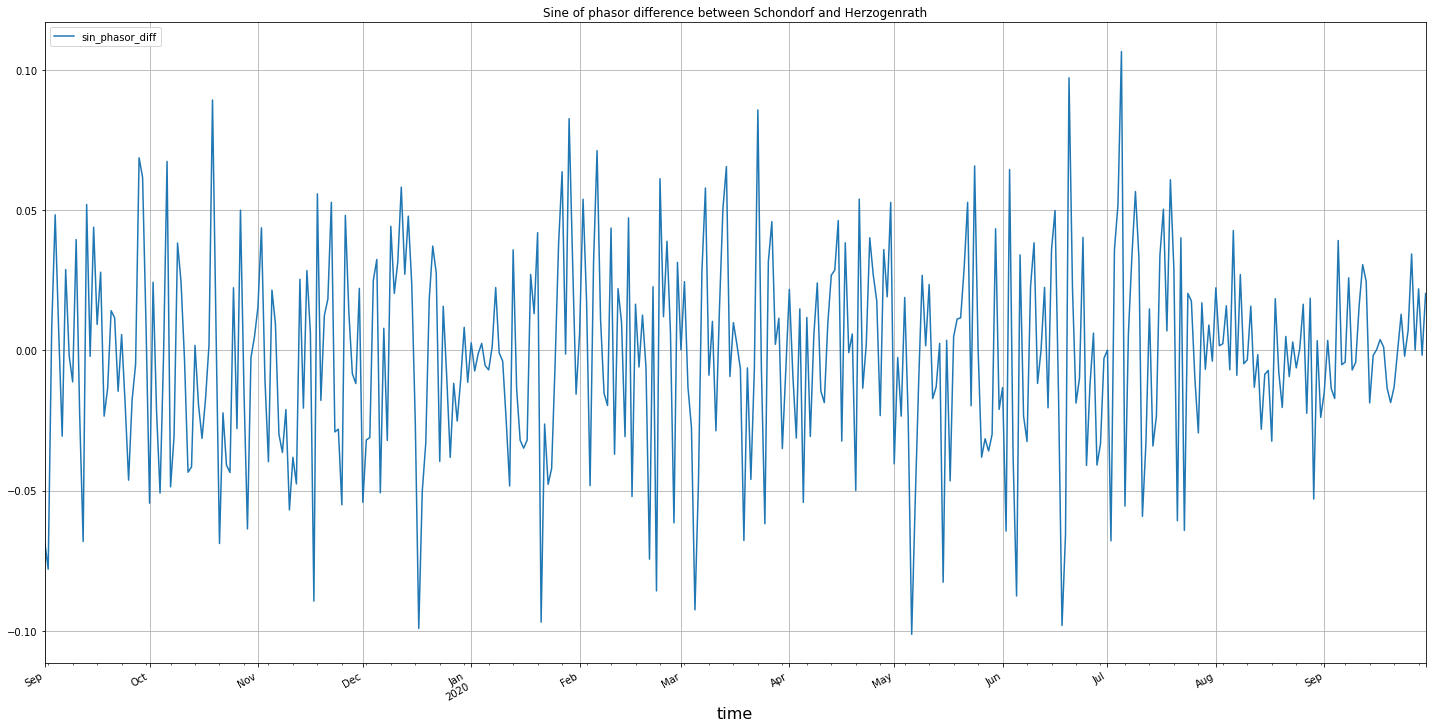

In [11]:
import math
import sympy as sp
#np.sin is not giving correct values, gotta figure it out

df['phasor_diff_rad']=np.deg2rad(df['Schondorf_phasor'] - df['Herzogenrath_phasor'])
df['sin_phasor_diff']=np.sin(np.deg2rad(df['Schondorf_phasor'] - df['Herzogenrath_phasor']))


df['sin_phasor_diff'].resample('D').mean().plot(grid = True, subplots=True, figsize = (20,10))
plt.xlabel('time', fontsize=16)
plt.legend(loc="upper left")
plt.tight_layout()
plt.title('Sine of phasor difference between Schondorf and Herzogenrath')

In [20]:
#Check data for stationarity and trend using Summary Statistics
#Results suggests data is stationary
X=df.Schondorf_phasor.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('\n *** Schondorf phasor data ***')
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

Y=df.Herzogenrath_phasor.values
split = round(len(X) / 2)
X1, X2 = Y[0:split], Y[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('\n *** Herzogenrath phasor data ***')
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

Z=df.Herzogenrath_freq.values
split = round(len(X) / 2)
X1, X2 = Z[0:split], Z[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('\n *** Herzogenrath frequency data ***')
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

A=df.Schondorf_freq.values
split = round(len(X) / 2)
X1, X2 = A[0:split], A[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('\n *** Schondorf frequency data ***')
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


 *** Schondorf phasor data ***
mean1=179.393788, mean2=179.442835
variance1=220.255694, variance2=237.367799

 *** Herzogenrath phasor data ***
mean1=179.713608, mean2=179.414011
variance1=203.870122, variance2=237.859298

 *** Herzogenrath frequency data ***
mean1=50.000037, mean2=49.999976
variance1=0.000213, variance2=0.000191

 *** Schondorf frequency data ***
mean1=49.997528, mean2=49.999968
variance1=0.121993, variance2=0.000221


In [21]:
#Check for stationarity using Dickey-Fuller test
#Results suggests we can reject Null hypothesis and confirms data is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('\n *** Schondorf phasor data ***')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
result = adfuller(Y)
print('\n *** Herzogenrath phasor data ***')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
result = adfuller(Z)
print('\n *** Herzogenrath frequency data ***')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
result = adfuller(A)
print('\n *** Schondorf frequency data ***')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


 *** Schondorf phasor data ***
ADF Statistic: -202.450422
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

 *** Herzogenrath phasor data ***
ADF Statistic: -116.231368
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

 *** Herzogenrath frequency data ***
ADF Statistic: -23.042618
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

 *** Schondorf frequency data ***
ADF Statistic: -202.523032
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


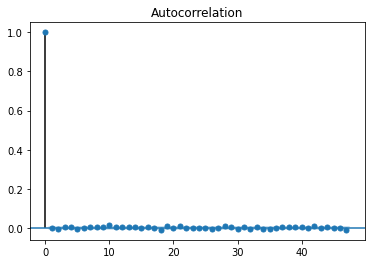

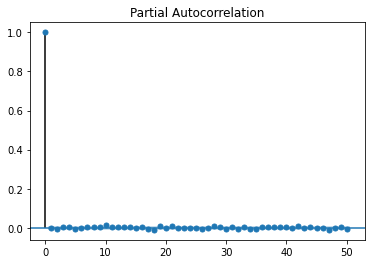

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.sin_phasor_diff)
plt.show()

plot_pacf(df.sin_phasor_diff, lags=50)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
#time has to be the index, univariate ARIMA
#df_new=phase_angle_df_imputed[['time','Schondorf']]
#df_new['time']=pd.to_datetime(df_new['time'],dayfirst=True)

X = df.Schondorf_freq.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize=(10,9))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()